Installing the libraries

In [12]:
!pip install -r requirements.txt

ERROR: Could not find a version that satisfies the requirement tensorflow==2.5.0 (from versions: 2.8.0rc1, 2.8.0, 2.8.1, 2.8.2, 2.8.3, 2.8.4, 2.9.0rc0, 2.9.0rc1, 2.9.0rc2, 2.9.0, 2.9.1, 2.9.2, 2.9.3, 2.10.0rc0, 2.10.0rc1, 2.10.0rc2, 2.10.0rc3, 2.10.0, 2.10.1, 2.11.0rc0, 2.11.0rc1, 2.11.0rc2, 2.11.0, 2.11.1, 2.12.0rc0, 2.12.0rc1, 2.12.0, 2.12.1, 2.13.0rc0, 2.13.0rc1, 2.13.0rc2, 2.13.0, 2.13.1, 2.14.0rc0, 2.14.0rc1, 2.14.0, 2.14.1, 2.15.0rc0, 2.15.0rc1, 2.15.0, 2.15.1, 2.16.0rc0, 2.16.1, 2.16.2, 2.17.0rc0, 2.17.0rc1, 2.17.0, 2.17.1, 2.18.0rc0, 2.18.0rc1, 2.18.0rc2, 2.18.0, 2.18.1, 2.19.0rc0, 2.19.0)
ERROR: No matching distribution found for tensorflow==2.5.0

[notice] A new release of pip is available: 23.0.1 -> 25.1.1
[notice] To update, run: C:\Users\saf\OneDrive\Desktop\CNN_LSTM\venv\Scripts\python.exe -m pip install --upgrade pip


Import the libraries

In [1]:
import cv2
import os
import math
import random
import numpy as np
import datetime as dt 
import tensorflow as tf
from collections import deque
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, auc

from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.callbacks import EarlyStopping
from scikeras.wrappers import KerasClassifier


Random Seeds for consistent results on every execution

In [2]:
seed_constant = 27 
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

For visualization of dataset so that you can check if the datasets are on the correct classes (Does not serve any other purpose)

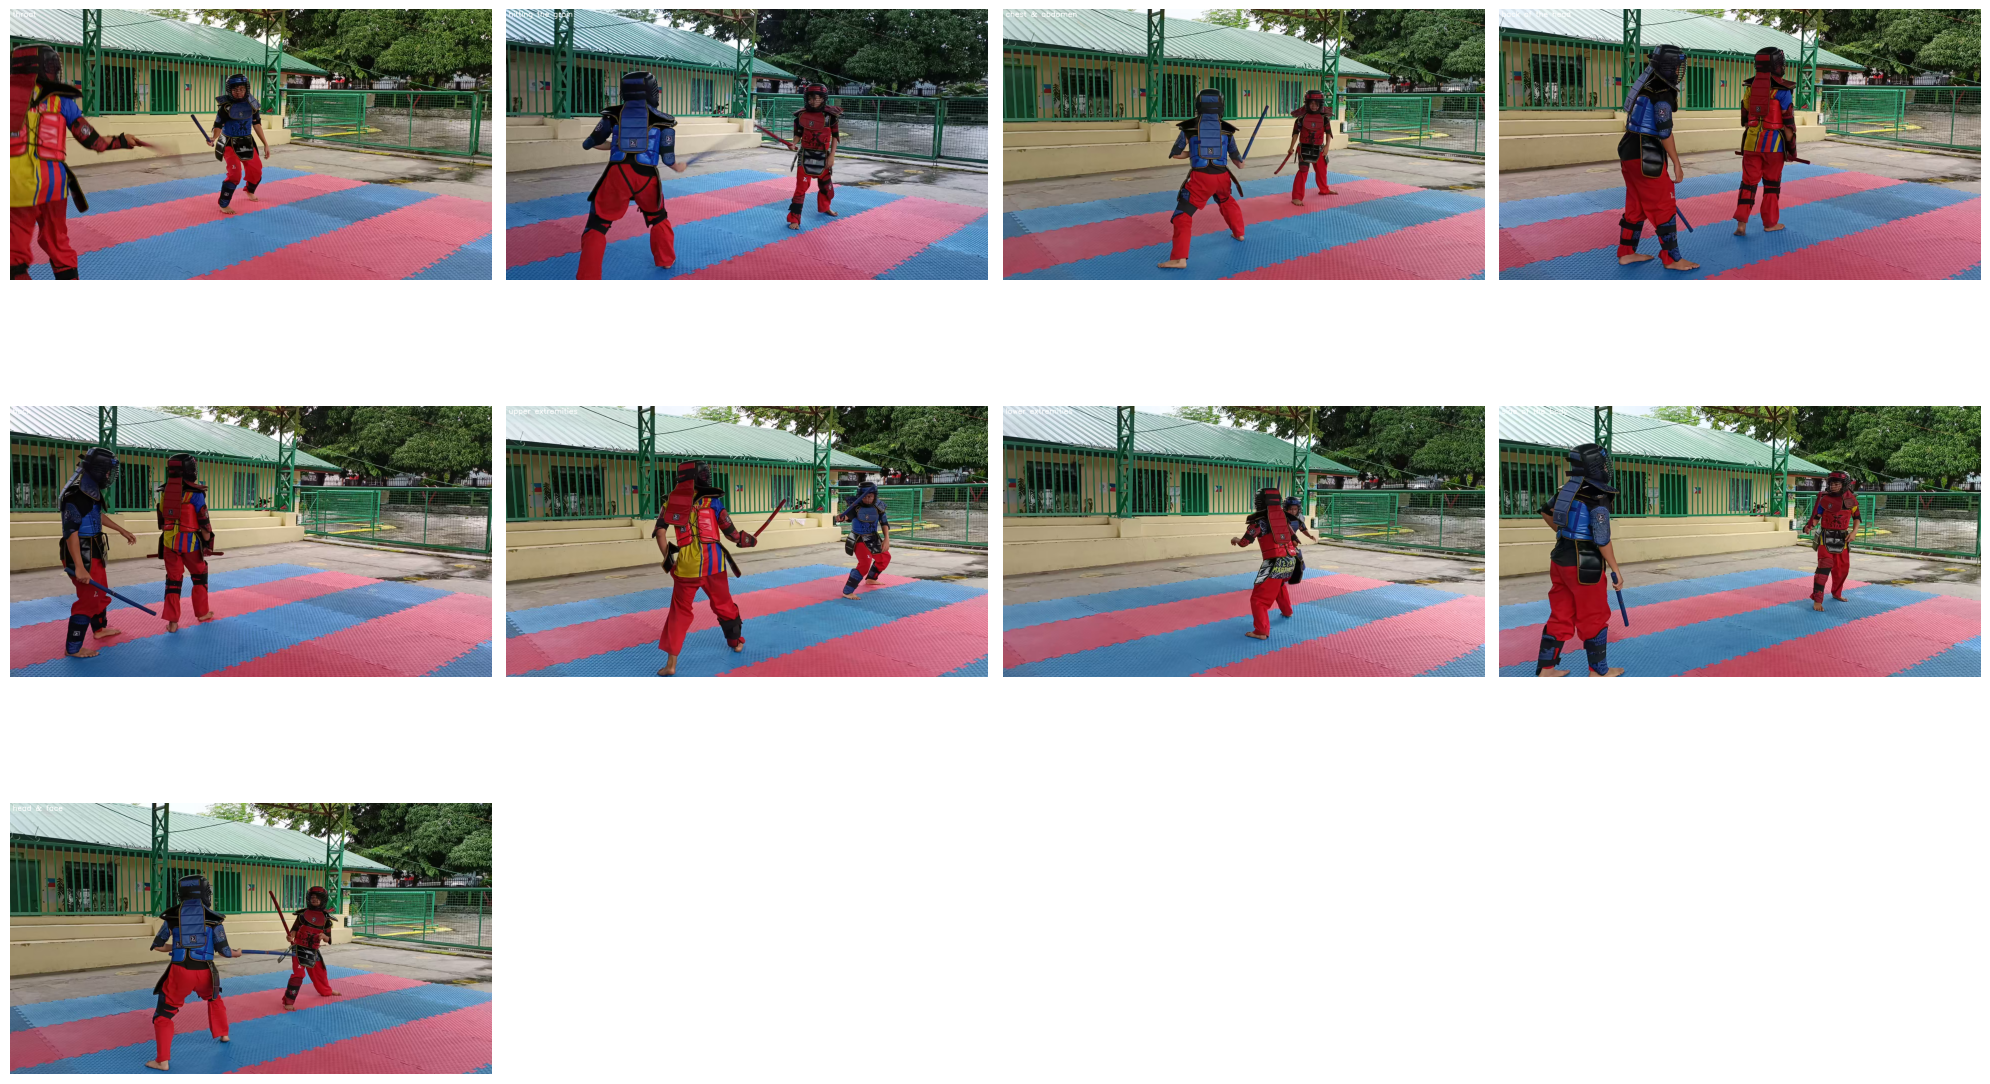

In [3]:
plt.figure(figsize=(20, 20))

all_classes_name = os.listdir('dataset')
random_range = random.sample(range(len(all_classes_name)), min(20, len(all_classes_name)))

for counter, random_index in enumerate(random_range, 1):
    selected_class_name = all_classes_name[random_index]
    video_files_names_list = os.listdir(f'dataset/{selected_class_name}')
    selected_video_file_name = random.choice(video_files_names_list)

    video_reader = cv2.VideoCapture(f"dataset/{selected_class_name}/{selected_video_file_name}")
    success, bgr_frame = video_reader.read()
    video_reader.release()

    rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)
    cv2.putText(rgb_frame, selected_class_name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2)

    plt.subplot(5, 4, counter)
    plt.imshow(rgb_frame)
    plt.axis("off")

plt.tight_layout()
plt.show()

Preprocessing the dataset


-Image Height & Weight: so that the frames will be fixed and consistent
-Sequence Length: the number of frames of for each video that we will extract
-Dataset Directory: set the directory of the datasets (it will be useful)
-Class List: define the dataset classes

In [4]:
IMAGE_HEIGHT, IMAGE_WIDTH = 224, 224
SEQUENCE_LENGTH = 20
DATASET_DIR = 'dataset'
CLASS_LIST = sorted([
    folder_name for folder_name in os.listdir(DATASET_DIR)
    if os.path.isdir(os.path.join(DATASET_DIR, folder_name))
])

print("Number of classes:", len(CLASS_LIST))
print("Class list:", CLASS_LIST)


Number of classes: 9
Class list: ['back', 'back of the head', 'chest & abdomen', 'head & face', 'hitting the groin', 'lower extremities', 'side of the body', 'throat', 'upper extremities']


In [5]:
def frames_extraction(video_path):
    frame_list = []
    video_reader = cv2.VideoCapture(video_path)
    vide_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
    skip_frames_window = max(int(vide_frames_count/SEQUENCE_LENGTH), 1)

    for frame_counter in range(SEQUENCE_LENGTH):
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)
        success, frame = video_reader.read()
        if not success:
            break
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        normalized_frame = resized_frame/255
        frame_list.append(normalized_frame)

    video_reader.release()
    return frame_list


In [6]:
def create_dataset():
    features = []
    labels = []
    video_file_paths = []

    for class_index, class_name in enumerate(CLASS_LIST):
        print(f"Extracting Data of the Class {class_name}")
        file_list = os.listdir(os.path.join(DATASET_DIR, class_name))
        file_list = file_list[:10] 

        for file_name in file_list:
            video_file_path = os.path.join(DATASET_DIR, class_name, file_name)
            frames = frames_extraction(video_file_path)
            if len(frames) == SEQUENCE_LENGTH:
                features.append(frames)
                labels.append(class_index)
                video_file_paths.append(video_file_path)

    features = np.array(features)
    labels = np.array(labels)
    return features, labels, video_file_paths


In [7]:
features, labels, video_file_paths = create_dataset()

Extracting Data of the Class back
Extracting Data of the Class back of the head
Extracting Data of the Class chest & abdomen
Extracting Data of the Class head & face
Extracting Data of the Class hitting the groin
Extracting Data of the Class lower extremities
Extracting Data of the Class side of the body
Extracting Data of the Class throat
Extracting Data of the Class upper extremities


In [8]:
one_hot_encoded_labels = to_categorical(labels)

In [9]:
features_train, features_test, labels_train, labels_test = train_test_split(
    features, one_hot_encoded_labels, test_size=0.3, shuffle=True, random_state=seed_constant)

Constructing the model

In [10]:
def create_convlstm_model(filters1=4, filters2=8, filters3=14, filters4=16, dropout_rate=0.2):
    model = Sequential()
    model.add(ConvLSTM2D(filters=filters1, kernel_size=(3, 3), activation='tanh',
                         data_format='channels_last', recurrent_dropout=dropout_rate,
                         return_sequences=True, input_shape=(SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3)))
    model.add(MaxPooling3D(pool_size=(1,2,2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(dropout_rate)))

    model.add(ConvLSTM2D(filters=filters2, kernel_size=(3, 3), activation='tanh',
                         data_format='channels_last', recurrent_dropout=dropout_rate, return_sequences=True))
    model.add(MaxPooling3D(pool_size=(1,2,2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(dropout_rate)))

    model.add(ConvLSTM2D(filters=filters3, kernel_size=(3, 3), activation='tanh',
                         data_format='channels_last', recurrent_dropout=dropout_rate, return_sequences=True))
    model.add(MaxPooling3D(pool_size=(1,2,2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(dropout_rate)))

    model.add(ConvLSTM2D(filters=filters4, kernel_size=(3, 3), activation='tanh',
                         data_format='channels_last', recurrent_dropout=dropout_rate, return_sequences=True))
    model.add(MaxPooling3D(pool_size=(1,2,2), padding='same', data_format='channels_last'))

    model.add(Flatten())
    model.add(Dense(len(CLASS_LIST), activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model


In [11]:
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV

model_wrapper = KerasClassifier(
    model=create_convlstm_model,
    epochs=10,
    batch_size=4,
    verbose=0
)

param_grid = {
    'model__filters1': [4, 8],
    'model__filters2': [8, 16],
    'model__filters3': [14, 20],
    'model__filters4': [16, 24],
    'model__dropout_rate': [0.2, 0.3]
}

grid = GridSearchCV(estimator=model_wrapper, param_grid=param_grid, cv=3)
grid_result = grid.fit(features_train, labels_train)

print("Best Parameters:", grid_result.best_params_)


d:\CNN_LSTM\venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
d:\CNN_LSTM\venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
d:\CNN_LSTM\venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


d:\CNN_LSTM\venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


d:\CNN_LSTM\venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
d:\CNN_LSTM\venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
d:\CNN_LSTM\venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
d:\CNN_LSTM\venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Seq

Best Parameters: {'model__dropout_rate': 0.2, 'model__filters1': 4, 'model__filters2': 8, 'model__filters3': 20, 'model__filters4': 24}


C:\Users\saf\AppData\Local\Temp\ipykernel_3404\5005726.py:11: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


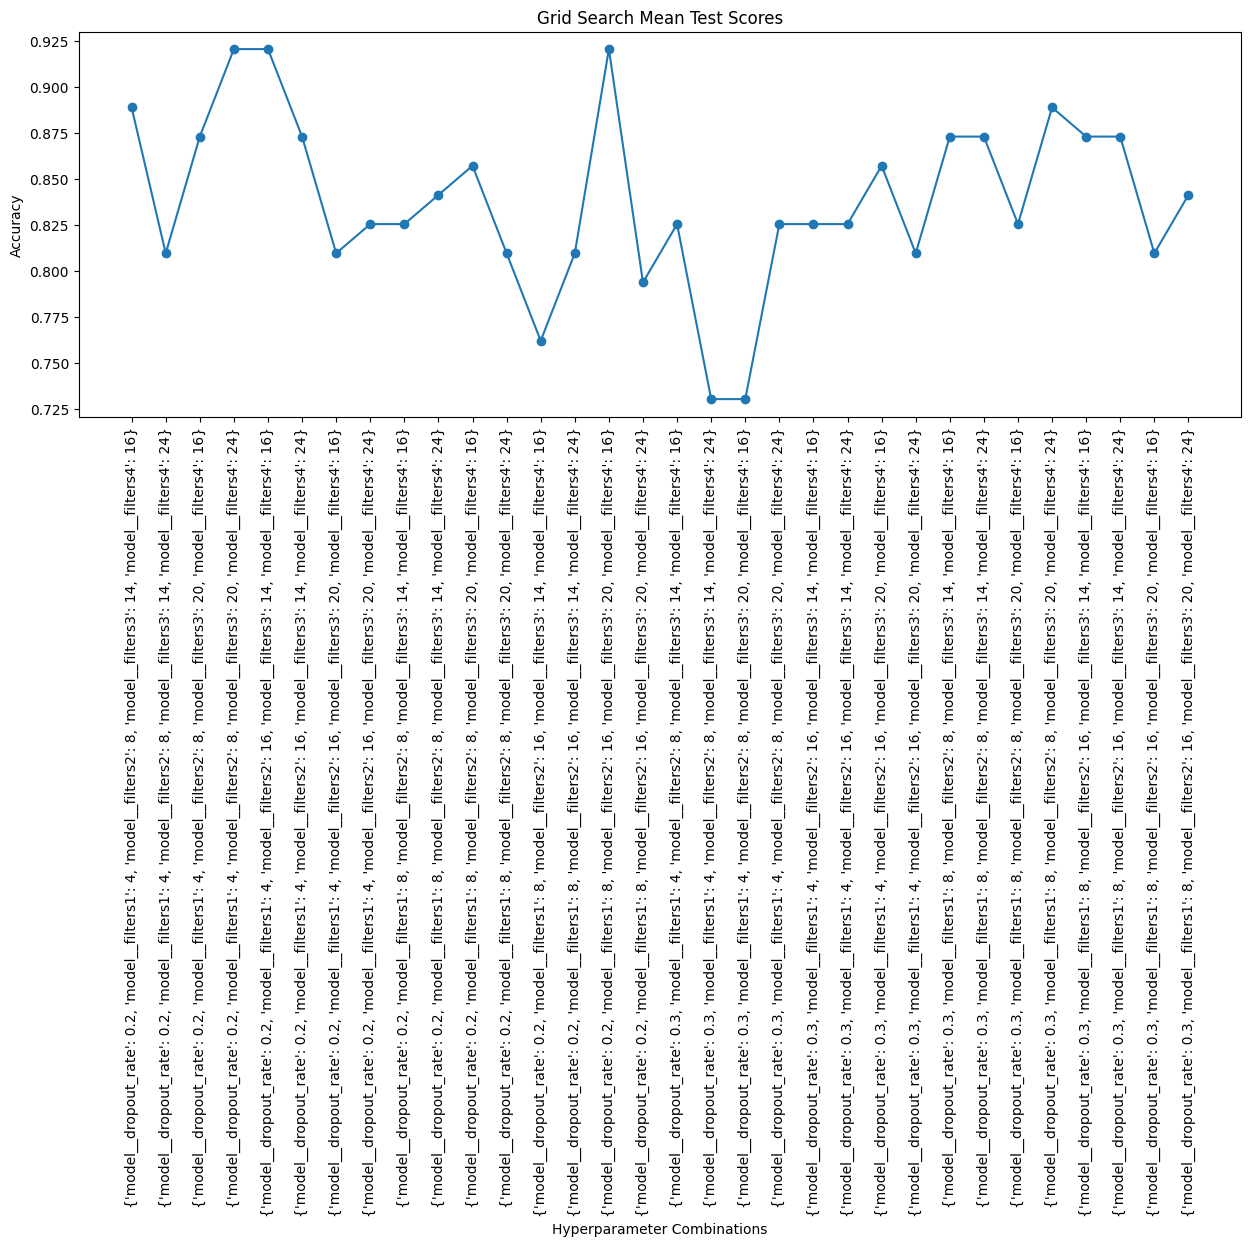

In [12]:
mean_test_scores = grid_result.cv_results_['mean_test_score']
params = grid_result.cv_results_['params']
param_labels = [str(p) for p in params]

plt.figure(figsize=(15, 5))
plt.plot(mean_test_scores, marker='o')
plt.xticks(ticks=range(len(param_labels)), labels=param_labels, rotation=90)
plt.title('Grid Search Mean Test Scores')
plt.xlabel('Hyperparameter Combinations')
plt.ylabel('Accuracy')
plt.tight_layout()
plt.show()

In [22]:
best_model = grid_result.best_estimator_.model_
preds = best_model.predict(features_test)

model_evaluate_history = best_model.evaluate(features_test, labels_test)
print("Evaluation on Test Data:", model_evaluate_history)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.9259 - loss: 0.0930
Evaluation on Test Data: [0.09299571067094803, 0.9259259104728699]


In [16]:
best_model.save('output/models/convlstm_final.h5')

Sample test code to verify the accuracy of the result outside the test datasets

In [ ]:
def predict_on_video(video_file_path, output_file_path, SEQUENCE_LENGTH):
    video_reader = cv2.VideoCapture(video_file_path)

    original_video_width = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
    original_video_height = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = video_reader.get(cv2.CAP_PROP_FPS)

    fourcc = cv2.VideoWriter_fourcc(*'mp4v')  
    video_writer = cv2.VideoWriter(
        output_file_path, fourcc, fps, (original_video_width, original_video_height)
    )

    frames_queue = deque(maxlen=SEQUENCE_LENGTH)
    predicted_class = ''

    while video_reader.isOpened():
        ok, frame = video_reader.read()
        if not ok:
            break

        resized_frame = cv2.resize(frame, (IMAGE_WIDTH, IMAGE_HEIGHT))
        normalized_frame = resized_frame / 255.0

        frames_queue.append(normalized_frame)

        if len(frames_queue) == SEQUENCE_LENGTH:
            input_frames = np.expand_dims(np.array(frames_queue), axis=0)
            predictions = convlstm_model.predict(input_frames, verbose=0)
            predicted_class = CLASS_LIST[np.argmax(predictions)]

        cv2.putText(frame, f"Prediction: {predicted_class}", (10, 30),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

        video_writer.write(frame)

    video_reader.release()
    video_writer.release()
    print(f"Prediction video saved to {output_file_path}")

In [ ]:
predict_on_video('test_vide2.mp4', 'output/videos/cnnlstm_test_output2.mp4', SEQUENCE_LENGTH)